<span style="color: red;">NOTE:  
    Sections marked TODO should be completed before final submission.  
    Delete this section when finished.</span>

# AI Academy Semester 1 Capstone

Last Updated: 2022-07-29  
Collaborators: A. Donahue, C. Lineman, N. Netznik, T.V. Nguyen, A. White

# <span style="color: blue;">Background</span>

<span style='color: red'>TODO</span>  
More specifically point out stakeholders (head of CV)

### Business Case

Original video content is a growing field into which many big businesses are investing. The client, Computing Vision, would like to begin creating their own original videos, so they are creating a new movie studio. They are seeking assistance in understanding the current trends in films, specifically which kinds movies are currently doing the best at the box office. They will use these insights to drive their own choices in movie creation.

### Scope

This study will use a variety of historic data on recent movie performance to illuminate trends in profitability and to develop actionable insights for the head of Computing Vision's new movie studio. We will limit data to the range of 2010-present (where available) to ensure that insights are still valid.

### Purpose

The results of this study will provide statistical support for at least three actionable insights that Computing Vision can use to **maximize profits and performance** from their new movie studio.

# <span style="color: blue;">Importing and Processing Data Sources</span>

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import scipy.stats as st
import math
import matplotlib.ticker as mticker

<span style='color: red'>TODO</span>  
Alex W.: Import and suppress warnings

In [200]:
#read data
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZipped/")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZipped/im.db")

Extracted all


### Data Sources

Our team has thoroughly reviewed 5 different sources of data in which we were able to pull detailed insights that will help lead Computing Vision to success in the movie creation realm. 

#### Sources

* Box Office Mojo(https://www.boxofficemojo.com/)
* IMDB (https://www.imdb.com/)
* Rotten Tomatoes (https://www.rottentomatoes.com/)
* TheMovieDB (https://www.themoviedb.org/)
* The Numbers (https://www.the-numbers.com/)

#### Box Office Mojo

Our team imported Data from Box Office Mojo as we found that it to be a credible resource that provided with a large amount of data and information regarding movie gross values. We successfully pulled and sized the data to present us with a data frame of 3387 movies including the movie title, the studio of production, the domestic and foreign gross values of each movie, and the year the movie was released as well. 



#### IMDB

Internet Movie Database (IMDb) is considered the largest and most comprehensive movie databases. This database provides information related to films, television series, home videos, video games, and streaming content. Our team found this source to be a valuable as it allowed us to view a large depository of movies specific information. This source allowed us to pull a wide arrange of data and source into different tables that includes information on movie personal, principals, directors, writer, rating, basics, etc.

#### Rotten Tomatoes 

Rotten Tomatoes is a review aggregation website for film and television. Rotten Tomatoes is one of the most trusted recommendations recourses for quality of entertainment. Rotten tomatoes specify in reviews from critics and provides a comprehensive guide on ratings for movies. We were able to use this source to specify the relation of Rotten Tomatoes rating and movies success. As well link these rating to several different aspects in which we give insights on throughout the analysis. This source was able to provide was with multiple different data frames in which our team use primarily in two which include data on Movie reviews and Movie specific information.  Regarding movie information we were successfully able to pull data on 1560 movies with details regarding synopsis, MPA Rating (PG, PG13, R, etc.), genre, director, writer, Theater date, DVD release date, currency, Box office sales, movie runtime, and production studio.  

As well with the use of Rotten tomatoes source we were able to import a data frame allowing us to view details on movie reviews. We were able to import 54432 data points that gave us compressive information regarding movie ID, distinct reviews, review rating, fresh/rotten specification, critic of the review, the top critic, publisher, and date of review. We must note that this data frame provided was with multiple reviews from different critics through different publishers on different dates for the movies. 


#### The MovieDB 

The Movie Database (TMDB) is a community-built movie and TV database. This data base was able to provide us insights on individual movie specifics and there rating.  We were able to successfully import 26517 movies with information regarding genre, language, title, popularity, release date, vote average and vote count regarding movie rating. 

#### The Numbers

The Numbers is a film industry data website that tracks box office revenue.  We primarily used this source to generate a data frame that provided information regarding movie budgets. Digging deeper we were able to pull information for 5782 movies with details on Release date, Movie title, production budget, domestic gross, and worldwide gross. Our team found this provided data to valuable in regards of generating profit percentage and movie success throughout our overall analysis. 

#### Limitations  

We must also note that our team did run into some limitations when it came to connecting and merging data frames due to differentiation in primary keys. Our team found that the best fit primary key to over come this issue was merging and connecting through movie titles. 

The specific limitation with the use of titles is that they could potentially be less consistent than numeric identifiers.

# <span style="color: blue;">Data Preparation & Cleaning</span>

In [201]:
# Turn foreign gross to an int
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

# Turned run time into an integer
movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")

# Turned box_offices into an interger
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")

# Change currency to binary variable
for i in movie_info['currency']:
    if i is not None:
        i = 1
    else:
        i = 0

# Update 'fresh'/'rotten' in reviews to boolean variable
reviews['fresh'] = reviews['fresh'].str.replace('fresh','1')
reviews['fresh'] = reviews['fresh'].str.replace('rotten','0')
reviews['fresh']  = reviews['fresh'].astype("float64")

reviews.drop_duplicates(inplace=True)

A brief analysis reveals that ratings within the Rotten Tomatoes reviews database are very inconsistent. We seek to clean and reorganize these ratings to make them usable.

We will make the following modifications to the ratings column:

* We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    * Note that F+ and F- will be grouped with F.
* We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before making further calculations in the future; upon performing these calculations we will go back and reset all '-1/1' values to NaN.

In [202]:
# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)
reviews['rating'].replace('5.5/5', '-1/1', inplace=True)

In [203]:
# Remove unwanted symbols from string values and cast string values as floats

movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

# Change type of release_date to datetime
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

# Clean titles to make them consistent/comparable

movie_gross['title'] = movie_gross['title'].str.strip().str.replace('[^\w\s]', '')
movies['original_title'] = movies['original_title'].str.strip().str.replace('[^\w\s]', '')
movie_budgets['movie'] = movie_budgets['movie'].str.replace("â€™", "'") # replaces improperly encoded ' characters
movie_budgets['movie'] = movie_budgets['movie'].str.strip().str.replace('[^\w\s]', '')

movie_gross['title'] = movie_gross['title'].str.upper()
movies['original_title'] = movies['original_title'].str.upper()
movie_budgets['movie'] = movie_budgets['movie'].str.upper()


# <span style="color: blue;">Analysis of Selected Variables</span>

## Budget vs. Profit Ratio

<span style="color: red;">TODO</span>  
Add justification and explanation

In [204]:
movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

movie_budgets.rename(columns = {'movie' : 'title'}, inplace = True)
grossJoinBudget = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

grossJoinBudget.fillna(0, inplace=True)

<span style='color: red'>TODO</span>  
Explain justification for 2 million cutoff point

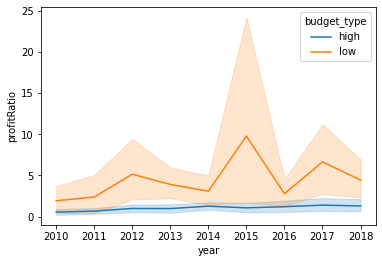

In [205]:
grossJoinBudget['budget_type'] = grossJoinBudget['production_budget'].map(lambda x: 'high' if x >= 20000000  else 'low' )

grossJoinBudget['profitRatio'] = (grossJoinBudget['profit'] - grossJoinBudget['production_budget']) / grossJoinBudget['production_budget']

sns.lineplot(x='year', y='profitRatio', hue='budget_type', data=grossJoinBudget);

#### Hypothesis test for budget vs profit ratios  
<span style='color: red'>TODO</span>  Revise hypothesis testing code/markdown to one-tailed test

We will conduct a one-tailed two sample t-test with a 5% level of significance to conclude whether low budget movies yield higher product ratios on average than high budget movies.

    Null: There is no difference in profit ratios between high and low budget movies.
    Alternative: Low budget movies yield higher product ratios on average than high budget movies.

<span style='color: red'>TODO</span>  
Colton: Change code to use earlier column

In [206]:
# s1 = grossJoinBudget.loc[high]['profitRatio']
# s2 = grossJoinBudget.loc[low]['profitRatio']

In [207]:
# type(s1)

In [208]:
# s2

In [209]:
# plt.boxplot([s1, s2]);

<span style='color: red'>TODO</span>  
Colton: Consider changing to IQR formula; move removing of outliers to earlier in section

In [210]:
# s1 = s1[(s1>np.quantile(s1,0.25)) & (s1<np.quantile(s1,0.75))].tolist()

In [211]:
# s2 = s2[(s2>np.quantile(s2,0.25)) & (s2<np.quantile(s2,0.75))].tolist()

In [212]:
# plt.boxplot([s1, s2]);

In [213]:
# # stat, pval = st.ttest_ind(s1,s2,equal_var = False)
# pval/2

**Conclusion:** We would reject the NULL  
<span style="color: red;">TODO</span>  
What does it mean? Include business recommendation.

## Genre vs. Profit Ratio

We want to take a look at how the major genres perform around the world relative to their global average performance to determine which genres are the most profitable.

In [214]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")



"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
sql_dataset_merge1['title'] = sql_dataset_merge1['title'].str.upper()

<span style='color: red'>TODO</span>  
Van: Do we need to show the tables every time?

In [215]:
#keep only original movie
sql_dataset_merge1= sql_dataset_merge1[sql_dataset_merge1.is_original_title==1]

data= movie_budgets.merge(sql_dataset_merge1, how= 'inner', left_on='title', right_on= 'title')

dataset= data[[ 'release_date', 'title', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'ordering']]



<span style='color: red'>TODO</span>  
Van: Justify dropping data

In [216]:
dataset=dataset.dropna()

In [217]:
## calulate profit by subtracting gross and budget and foreign gross by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
dataset['foreign_gross']= dataset['worldwide_gross']- dataset['domestic_gross']
# dataset.loc[dataset['profit'] < 0, 'profit']= 0
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] - dataset['production_budget']) / dataset['production_budget']

I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.


In [218]:
df_split_genre = dataset.copy()
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)

# limit data to 2010-present
df_split_genre = df_split_genre.loc[df_split_genre['release_date'].dt.year >= 2010]

<span style='color: red'>TODO</span>  
Remove extraneous text below?

### Visualize dataset

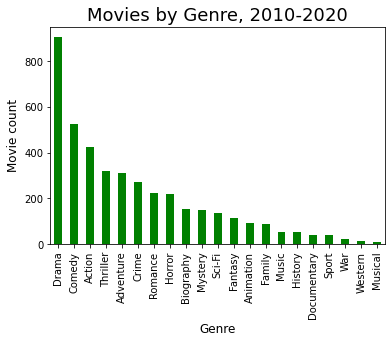

In [219]:
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movies by Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas and comedies top the list ( in North America) between 2010 and 2020 as more than 500 comedy films were released and over 900 drama films have been released.

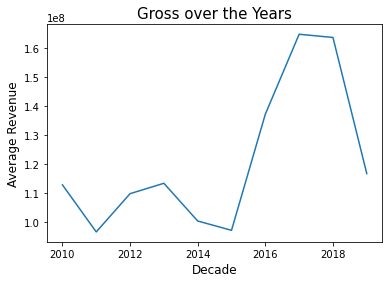

In [220]:
#line gross
gross_mean= df_split_genre.groupby(df_split_genre['start_year'])['worldwide_gross'].mean()
plt.plot(gross_mean)
plt.title('Gross over the Years', size=15);
plt.xlabel('Decade', size=12)
plt.ylabel('Average Revenue', size=12);

<span style="color: red">TODO</span>  
Move this up somewhere

In [221]:
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)

### Hypothesis testing

<span style="color: red;">TODO</span>  
Declare H0/HA; set alpha=0.05

In [222]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(genre_split),13114.623621,20.0,4.176862,1.264954e-09
Residual,648845.153437,4133.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genre.

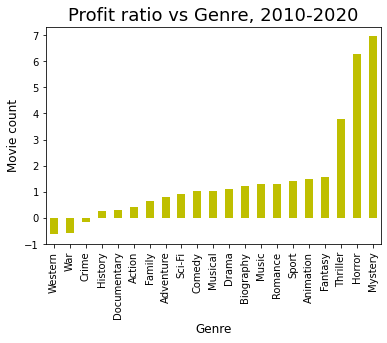

In [223]:
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

<span style="color: red">TODO</span>  
Move this up for posterity

In [224]:
  
# display model summary
# print(model.summary())


From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

Note: When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey's HSD test).

We have Tukey’s HSD test for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)
 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [225]:
 !pip install bioinfokit;

In [226]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Action,Adventure,0.379659,-2.958043,3.717362,0.574543,0.9
1,Action,Animation,1.042500,-4.057050,6.142049,1.032571,0.9
2,Action,Biography,0.778788,-3.459530,5.017105,0.928115,0.9
3,Action,Comedy,0.584592,-2.334785,3.503969,1.011437,0.9
4,Action,Crime,0.592273,-2.884896,4.069442,0.860344,0.9
...,...,...,...,...,...,...,...
205,Sport,War,1.992699,-9.772479,13.757876,0.855498,0.9
206,Sport,Western,2.027741,-11.914754,15.970235,0.734595,0.9
207,Thriller,War,4.370089,-5.290576,14.030753,2.284858,0.9
208,Thriller,Western,4.405130,-7.813797,16.624058,1.820965,0.9


<span style="color: red">TODO</span>  
Show only the important results from this call

In [227]:
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
10,Action,Horror,5.841909,2.126565,9.557253,7.942036,0.001000
125,Drama,Mystery,5.846141,1.878267,9.814016,7.441962,0.001000
122,Drama,Horror,5.174124,1.810251,8.537996,7.769147,0.001000
98,Crime,Mystery,7.106200,2.532261,11.680139,7.847351,0.001000
83,Comedy,Mystery,5.929335,1.763644,10.095025,7.189439,0.001000
80,Comedy,Horror,5.257317,1.662239,8.852395,7.386383,0.001000
95,Crime,Horror,6.434182,2.373083,10.495282,8.002502,0.001000
32,Adventure,Mystery,6.134267,1.665434,10.603101,6.933373,0.001000
29,Adventure,Horror,5.462250,1.519905,9.404594,6.998307,0.001000
13,Action,Mystery,6.513927,2.244012,10.783841,7.705481,0.001000


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences.

# Nate work
<span style='color: red'>TODO</span>  
Rename this

### Creating New Columns
<span style="color: red;">TODO</span>  
Add markdown to explain feature engineering

In [228]:
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10

In [229]:
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

# Exploratory Data Analysis on Rotten Tomatoes Reviews

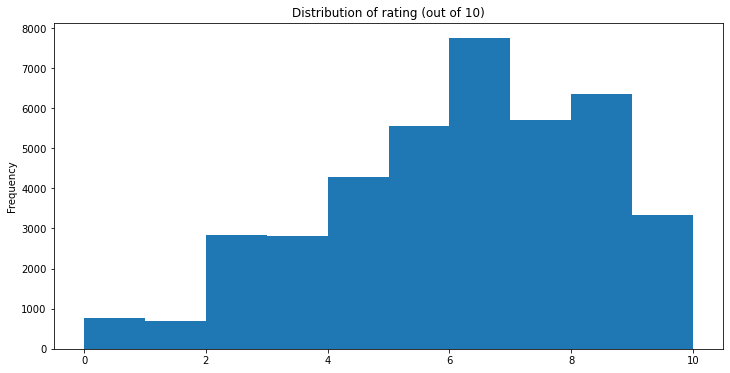

In [230]:
reviews['rating_out_of_10'].plot(figsize=(12,6), kind='hist', title='Distribution of rating (out of 10)');

In [231]:
reviews['rating_out_of_10'].mean()

5.91708490119365

In [232]:
reviews['rating_out_of_10'].median()

6.0

In [233]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

We have found that movies average **6 out of 10 stars**. We could consider movies with below 6 out of 10 stars to be below average and movies with above 6 out of 10 stars to be above average.

# Research Question
Do a **director's previous movie ratings** relate to the **profit** that their movies generate?

## Approach
To answer this question, we will begin by creating two groups of directors - those with a "good" average rating, and those with a "bad" average rating. We will determine a threshold by which we can classify ratings as "good" or "bad" by investigating the distribution of Rotten Tomatoes rating data within movies classified by Rotten Tomatoes as "fresh" and those classified as "rotten", as well as considering the results from the exploratory data analysis performed above.

Upon choosing a threshold, we will use IMDB databases joined with movie budget data from The Numbers to calculate mean movie rating by director along with the director's mean profit. In particular, we are interested in established directors - those who have received over 1,000 reviews and have worked on at least two movies. We will then split these directors into two groups - one group with mean ratings of greater than or equal to the threshold, and one with mean ratings below the threshold.

We will then investigate whether there is a relationship between mean rating by director and their mean profit. We will conduct a hypothesis test to determine if the mean profit for established directors with the higher mean ratings is greater than that of established directors with the lower mean ratings.

### Determining a Threshold

In [234]:
rotten_tomatoes = movie_info.merge(reviews, on='id')

In [235]:
fresh_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 1]
rotten_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 0]

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


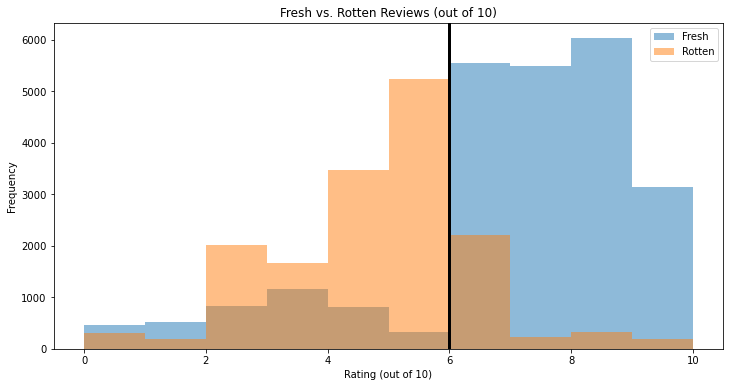

In [236]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(fresh_reviews['rating_out_of_10'], alpha=0.5)
ax.hist(rotten_reviews['rating_out_of_10'], alpha=0.5)
ax.set_title("Fresh vs. Rotten Reviews (out of 10)")
ax.set_xlabel("Rating (out of 10)")
ax.set_ylabel("Frequency")
ax.legend(['Fresh','Rotten'])
plt.axvline(x=6, color='black', lw=3);

Based upon the visualization above, as well as the distribution of ratings investigated in the preceding exploratory data analysis on Rotten Tomatoes reviews, we will set our threshold to **6 out of 10**.

### Gathering Data

In [237]:
movie_budgets['profit'] = movie_budgets['worldwide_gross']-movie_budgets['production_budget']

In [238]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

In [239]:
directorRatings['title'] = directorRatings['title'].str.upper()

In [240]:
budgetJoinDirector = movie_budgets.merge(directorRatings, left_on = 'title', right_on='title')

To obtain relevant data, we will only focus on data since **2010**:

In [241]:
budgetJoinDirector['year'] = budgetJoinDirector['release_date'].dt.year

In [242]:
budgetJoinDirector = budgetJoinDirector.loc[budgetJoinDirector['year'] >= 2010]

In [243]:
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)


In [244]:
budgetJoinDirector['profit'] = budgetJoinDirector['worldwide_gross']-budgetJoinDirector['production_budget']
budgetJoinDirector['profitRatio'] = (budgetJoinDirector['worldwide_gross'] - budgetJoinDirector['production_budget'])/ budgetJoinDirector['production_budget']

In [245]:
budgetJoinDirector['positive_review'] = budgetJoinDirector['AVG_Movie_rating'] >= 6

In [246]:
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

### Investigating Data

<span style="color: red;">TODO</span>  
Elaborate on profit vs. profit ratio comparisons

In [247]:
avg_movie_rating = grouped['AVG_Movie_rating']
avg_profit = grouped['profit']
profitRatioGroup = grouped['profitRatio']

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean movie rating per director')

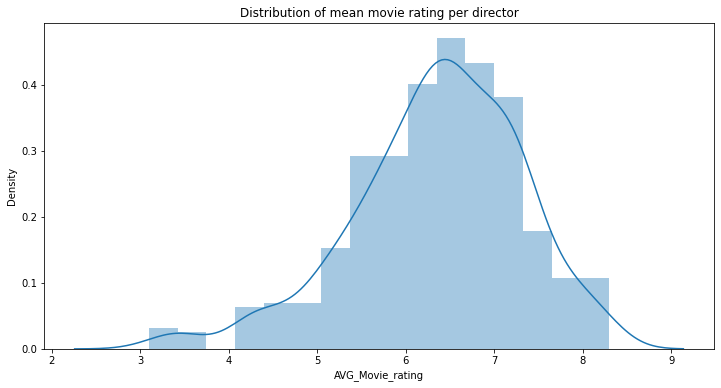

In [248]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating)
ax.set_title('Distribution of mean movie rating per director')

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean profit per director')

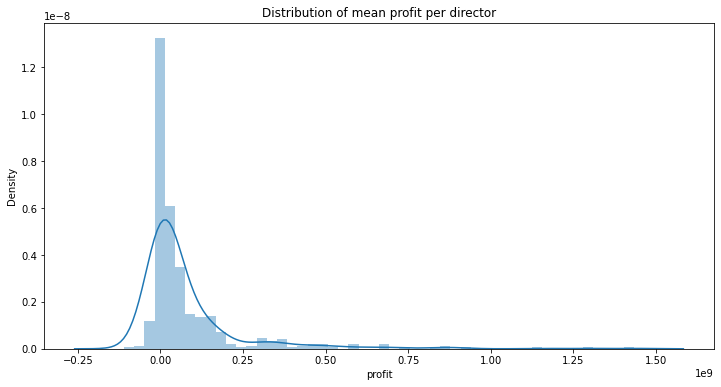

In [249]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_profit)
ax.set_title('Distribution of mean profit per director')

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

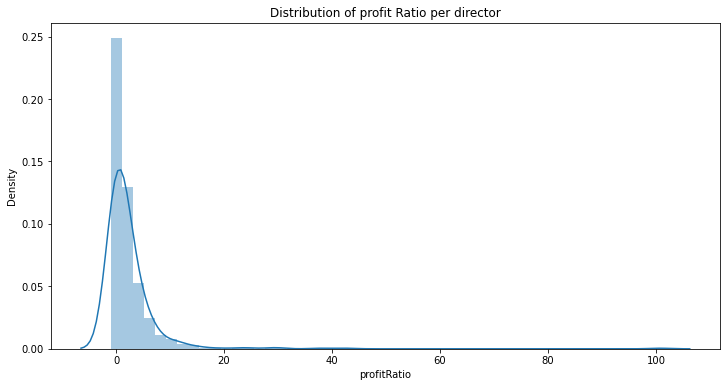

In [250]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(profitRatioGroup)
ax.set_title('Distribution of profit Ratio per director')

It appears that our profit data contains several outliers. We will trim these outliers using the **IQR rule** before proceeding with our analysis so we can focus on typical profits.

### Investigating Trimmed Data

In [251]:
Q1 = grouped['profit'].quantile(0.25)
Q3 = grouped['profit'].quantile(0.75)
IQR = Q3-Q1
grouped_trimmed = grouped.loc[(grouped['profit'] >= Q1-1.5*IQR) & (grouped['profit'] <= Q3 + 1.5*IQR)]

avg_movie_rating = grouped_trimmed['AVG_Movie_rating']
avg_profit = grouped_trimmed['profit']

In [252]:
Q1 = grouped['profitRatio'].quantile(0.25)
Q3 = grouped['profitRatio'].quantile(0.75)
IQR = Q3-Q1

grouped_clean = grouped.loc[(grouped['profitRatio'] >= Q1-(1.5*IQR)) & (grouped['profitRatio'] <= Q3 + 1.5*IQR)]

profitRatio = grouped_clean['profitRatio']
avg_movie_rating_ratio = grouped_clean['AVG_Movie_rating']

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of mean movie rating per director')

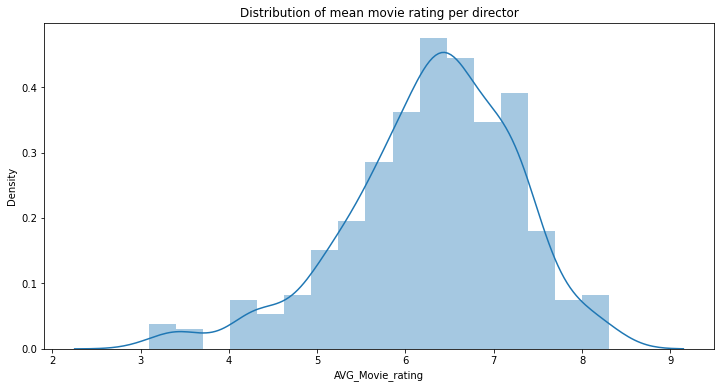

In [253]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating)
ax.set_title('Distribution of mean movie rating per director')

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


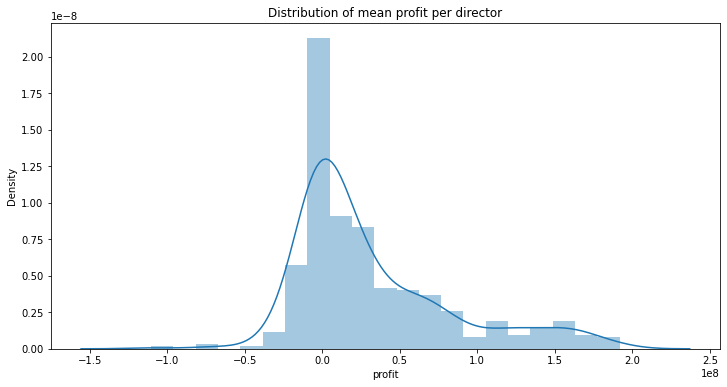

In [254]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_profit)
ax.set_title('Distribution of mean profit per director');

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

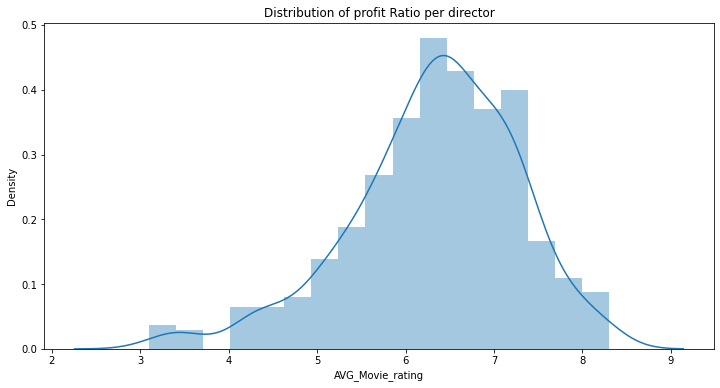

In [255]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(avg_movie_rating_ratio)
ax.set_title('Distribution of profit Ratio per director')


C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of profit Ratio per director')

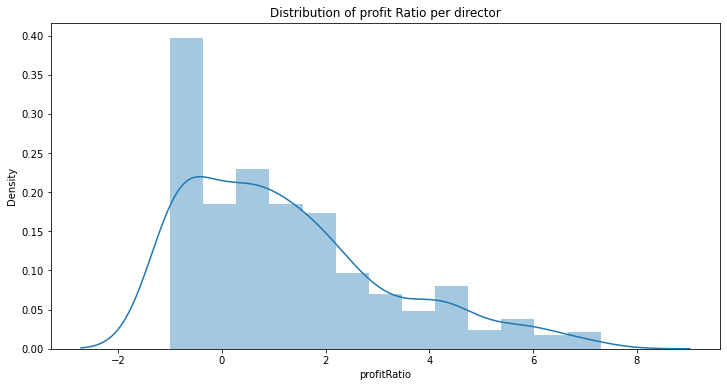

In [256]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(profitRatio)
ax.set_title('Distribution of profit Ratio per director')

In [257]:
greaterThanEqual6_trimmed = grouped_trimmed.loc[avg_movie_rating >= 6]['profit']
lessThan6_trimmed = grouped_trimmed.loc[avg_movie_rating < 6]['profit']

In [258]:
greaterThanEqual6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] >= 6]['profitRatio']
lessThan6_trimmed_ratio = grouped_clean.loc[grouped_clean['AVG_Movie_rating'] < 6]['profitRatio']

<span style='color: red'>TODO</span>  
Nate: Move these plots to a side-by-side format

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


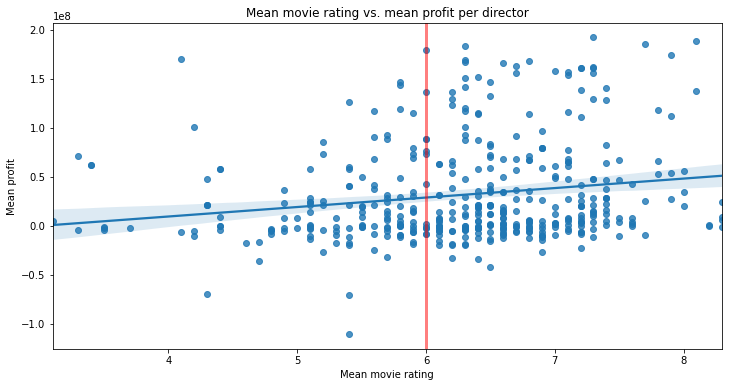

In [259]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.regplot(avg_movie_rating, avg_profit)
ax.axvline(6, color='red', lw=3, alpha=0.5);
ax.set_title('Mean movie rating vs. mean profit per director')
ax.set_xlabel('Mean movie rating')
ax.set_ylabel('Mean profit');

C:\Users\aldonahue\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


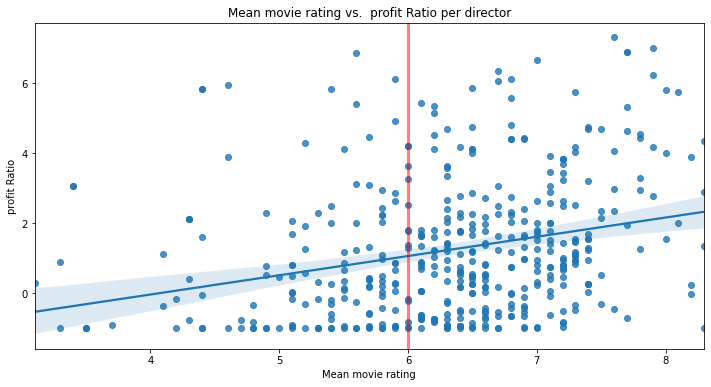

In [260]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.regplot(avg_movie_rating_ratio, profitRatio )
ax.axvline(6, color='red', lw=3, alpha=0.5);
ax.set_title('Mean movie rating vs.  profit Ratio per director')
ax.set_xlabel('Mean movie rating')
ax.set_ylabel('profit Ratio');

In [261]:
#for the profit
np.corrcoef(avg_movie_rating, avg_profit)[0][1]

0.180997452442317

In [262]:
greaterThanEqual6_trimmed.mean()

37372798.47979798

In [263]:
lessThan6_trimmed.mean()

18683923.664233577

In [264]:
greaterThanEqual6_trimmed.mean() - lessThan6_trimmed.mean()

18688874.815564405

In [265]:
greaterThanEqual6_trimmed.std(ddof=1)**2

2851196205844287.0

In [266]:
lessThan6_trimmed.std(ddof=1)**2

1744435558069636.8

In [267]:
#fir the profit ratio
np.corrcoef(avg_movie_rating_ratio, profitRatio)[0][1]

0.2689343683676368

#### Observations
* There is a **slight positive correlation** between mean movie rating per director and mean profit.

* The means of these two categories **differ**.
* The variances of these two categories **differ**.

## Rationale and Analysis
<span style="color: red;">TODO</span>  
Consider more simple graphs to visualize things

Using $\alpha=0.05$, we will conduct a one-tailed unpaired Welch's t-test (which does NOT assume that population variances are equal) to test our hypothesis that established directors with a mean rating of greater than or equal to 6 produce a greater mean profit than those with a mean rating of less than 6.

Let:
> $\mu_{GE6}$ denote the mean profit for directors with a mean rating of greater than or equal to 6;

> $\mu_{L6}$ denote the mean profit for directors with a mean rating of less than 6.

$H_{0}: \mu_{GE6} - \mu_{L6} = 0$

$H_{A}: \mu_{GE6} - \mu_{L6} > 0$

In [268]:
#for profit
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed, lessThan6_trimmed, equal_var=False)
pvalue/2

4.686646375630644e-05

In [269]:
#for profit ratio
statistic, pvalue = st.ttest_ind(greaterThanEqual6_trimmed_ratio, lessThan6_trimmed_ratio, equal_var=False)
pvalue/2

5.2855105942360924e-05

### Conclusion
If both groups do produce the same profits, there is approximately a 0.19% chance that we obtain a difference in sample means at least as large as obtained above. Given this probability and $\alpha=0.05$, we conclude that established directors with a mean rating of greater than or equal to 6 produce **greater mean profits** than those with a mean rating of less than 6, with a 5% chance of committing a type I error..

## Recommendation
We recommend that ...  
<span style='color: red'>TODO</span>  
Nate

## Season vs. Gross Profit 

<span style='color: red'>TODO</span>  
Alex D. (or Colton): Create explanatory markdown and comment code  
Add conclusion  
Add business suggestion

# Research Question

##### Is there a direct correlation in which season a movie is released and the gross profits generated?

# Approach

We will begin by making needed adjustments to to the movie budgets and movie gross data frames. Following the required adjustments we will merge the two data frames into one. We will then filter and clean the merged data frame to till we recieve the desired output to run our statistical analysis and create the appropriate visualizions that compare season relase date to gross profits

separate release date

Create new collumn as release month

In [270]:
release_month = movie_budgets['release_date'].dt.strftime('%m')
movie_budgets['release_month']= release_month

Create new collumn for relase year

In [271]:
release_year = movie_budgets['release_date'].dt.strftime('%Y')
movie_budgets['release_year']= release_year

In [272]:
#create dictionary to set individual month number to correlated season
#Season: spring = 1, summer=2, fall= 3, winter=4
season_dict = {'01': '4',
               '02': '4',
               '03': '1', 
               '04': '1',
               '05': '1',
               '06': '2',
               '07': '2',
               '08': '2',
               '09': '3',
               '10': '3',
               '11': '3',
               '12': '4'}
movie_budgets['Season'] = movie_budgets['release_month'].apply(lambda x: season_dict[x])

convert relase month, release year, and season to integers

In [273]:
movie_budgets['release_year']  = movie_budgets['release_year'].astype("int")
movie_budgets['release_month']  = movie_budgets['release_month'].astype("int")
movie_budgets['Season']  = movie_budgets['Season'].astype("int")

#### Merge Gross and budgets

In [274]:
movieGrossJoinBudgets = pd.DataFrame.merge(movie_gross, movie_budgets, on = 'title')

Check for null values

Set Null Values to 0 because it is assumed that if there is no value for foreign and domestic markets that there were no sales in that market. Changing null values to 0 allowed us to build a better analysis

In [275]:
movieGrossJoinBudgets.fillna(0, inplace = True)

calculate for inflations in the merged data frame. This will give us a more accurate representation of the data

In [276]:
i = 0
for row in movieGrossJoinBudgets.itertuples(index = False):
    if row[4] == 2010:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((8*.0151) + 1)

    if row[4] == 2011:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((7*.0151) + 1)

    if row[4] == 2012:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((6*.0151) + 1)

    if row[4] == 2013:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((5*.0151) + 1)

    if row[4] == 2014:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((4*.0151) + 1)

    if row[4] == 2015:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((3*.0151) + 1)

    if row[4] == 2016:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((2*.0151) + 1)

    if row[4] == 2017:
        movieGrossJoinBudgets.iat[i,2] = row[2] * ((1*.0151) + 1)

    i +=1

In [277]:
i = 0
for row in movieGrossJoinBudgets.itertuples(index = False):
    if row[4] == 2010:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((8*.0151) + 1)

    if row[4] == 2011:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((7*.0151) + 1)

    if row[4] == 2012:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((6*.0151) + 1)

    if row[4] == 2013:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((5*.0151) + 1)

    if row[4] == 2014:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((4*.0151) + 1)

    if row[4] == 2015:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((3*.0151) + 1)

    if row[4] == 2016:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((2*.0151) + 1)

    if row[4] == 2017:
        movieGrossJoinBudgets.iat[i,3] = row[3] * ((1*.0151) + 1)

    i +=1

In [278]:
#Drop collumn domestic_gross_y
# before this step there were two domestic gross collumns and this collumn is not needed for our analysis
movieGrossJoinBudgets.drop(['domestic_gross_y'], axis=1, inplace=True)

In [279]:
#group the merged datafram by seasons.
#use group data mean values.
#We are mesureing the the gross profit for each season. 
GrossJoinBudgetGrouped = movieGrossJoinBudgets.groupby('Season').mean()

In [280]:
#Drop all unneeded collumns for the remainder of the analysis.
GrossJoinBudgetGrouped.drop(['year', 'id', 'production_budget', 'worldwide_gross', 'release_month', 'release_year', 'profit'], axis=1, inplace=True)

Remove Outliers

In [281]:
Q1 = movieGrossJoinBudgets['domestic_gross_x'].quantile(0.25)
Q3 = movieGrossJoinBudgets['domestic_gross_x'].quantile(0.75)
IQR = Q3 - Q1

grouped_trimmed = movieGrossJoinBudgets.loc[(movieGrossJoinBudgets['domestic_gross_x'] >= Q1-1.5*IQR) & (movieGrossJoinBudgets['domestic_gross_x'] <= Q3 + 1.5*IQR)]

domSpring = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 1)]['domestic_gross_x']
domSummer = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 2)]['domestic_gross_x']
domFall = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 3)]['domestic_gross_x']
domWinter = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 4)]['domestic_gross_x']

In [282]:
Q1 = movieGrossJoinBudgets['foreign_gross'].quantile(0.25)
Q3 = movieGrossJoinBudgets['foreign_gross'].quantile(0.75)
IQR = Q3 - Q1

grouped_trimmed = movieGrossJoinBudgets.loc[(movieGrossJoinBudgets['foreign_gross'] >= Q1-1.5*IQR) & (movieGrossJoinBudgets['foreign_gross'] <= Q3 + 1.5*IQR)]

forSpring = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 1)]['foreign_gross']
forSummer = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 2)]['foreign_gross']
forFall = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 3)]['foreign_gross']
forWinter = grouped_trimmed.loc[(movieGrossJoinBudgets['Season'] == 4)]['foreign_gross']

Creat a chart to represent the data

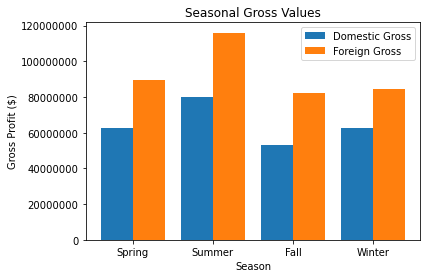

In [283]:
w=0.4
x = ['Spring', 'Summer', 'Fall', 'Winter']
domestic_gross_x = [6.286046e+07, 8.006786e+07, 5.330879e+07, 6.289587e+07]
foreign_gross = [8.961715e+07, 1.160124e+08, 8.214393e+07, 8.460717e+07]

bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]

plt.bar(bar1,domestic_gross_x,w,label='Domestic Gross')
plt.bar(bar2,foreign_gross,w,label='Foreign Gross')
plt.title('Seasonal Gross Values')
plt.xticks(bar1+w/2,x)
plt.xlabel('Season')
plt.ylabel('Gross Profit ($)')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.show()

Here we see a bar chart comparing the average gross profit for each season of the movies from the data's release date. The chart looks to clearly show that summer release dates generate the highest gross profit. Now let us test this through a hypthoesis test.

#### Hypothesis Testing

##### Hypothesis
    Null: There is no significant difference between the summer release dates and non summer release dates. H0:𝜇 ≥ 𝑥¯  
    Alternative: The the gross value is significantly bigger when released than not released in summer mean. 𝐻𝑎: 𝜇<𝑥¯
    Alpha= .02

**We will be performing a one sample T-test**  


In [284]:
winter = movieGrossJoinBudgets['Season'].values == 4
spring = movieGrossJoinBudgets['Season'].values == 1
fall = movieGrossJoinBudgets['Season'].values == 3

forSpring = movieGrossJoinBudgets.loc[spring]['foreign_gross']
domSpring = movieGrossJoinBudgets.loc[spring]['domestic_gross_x']
forFall = movieGrossJoinBudgets.loc[fall]['foreign_gross']
domFall = movieGrossJoinBudgets.loc[fall]['domestic_gross_x']
forWinter = movieGrossJoinBudgets.loc[winter]['foreign_gross']
domWinter = movieGrossJoinBudgets.loc[winter]['domestic_gross_x']

In [303]:
# T-test for foriegn market in summer
stat, pval = st.ttest_1samp(forSummer, movieGrossJoinBudgets['foreign_gross'].mean())
print(pval)

4.851278390839621e-27


In [305]:
#T-test for domestic market for summer
stat, pval = st.ttest_1samp(domSummer, movieGrossJoinBudgets['domestic_gross_x'].mean())
print(pval)

3.2163076229497447e-07


#  Decision

Since pvalue both pvalue for foreign and domestic gross are less than an alpha = .02 we reject the null.  
Stating that we are 98% sure that movies released in the Summer will result in larger gross profits.

## ANOVA Test



Ho: There is no significant differnce in gross profit values between seasons

Ha: There is a significant difference in gross profit values between seasons

Alpha =0.02

In [287]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('foreign_gross ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),2.427040e+17,3.0,3.382495,0.017637
Residual,3.116469e+19,1303.0,NaN,NaN


In [288]:
model = ols('domestic_gross_x ~ C(Season)', data=movieGrossJoinBudgets).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Season),1.279204e+17,3.0,5.427947,0.001037
Residual,1.023593e+19,1303.0,NaN,NaN


We conclude that there is a statistical difference between at least one pair of seasons. 

We will test summer against each season to see if it performs significantly better than each.

#### Now lets test summer to each season of the year 

In [289]:
#summer vs spring: foreign
stat, pval = st.ttest_ind(forSummer,forSpring,equal_var = False)
pval/2

2.1869211270872725e-05

In [290]:
#summer vs fall: fororeing
stat, pval =st.ttest_ind(forSummer,forFall,equal_var = False)
pval/2

2.4614528754853014e-05

In [291]:
#summer vs winter: foreign
stat, pval =st.ttest_ind(forSummer,forWinter,equal_var = False)
pval/2

1.256499056325375e-05

In [292]:
#summer vs spring: Domestic
stat, pval =st.ttest_ind(domSummer,domSpring,equal_var = False)
pval/2

0.015404473777821429

In [293]:
#summer vs fall: domestic
stat, pval =st.ttest_ind(domSummer,domFall,equal_var= False)
pval/2

0.2216923676198902

In [294]:
#summer vs winter: domestic
stat, pval =st.ttest_ind(domSummer,domWinter,equal_var = False)
pval/2

0.008295581757871684

Given alpha=0.02:
* We found a significant conclusion that summer is greater than all other seasons for the foreign market.
* We found a significant conclusion that summer is greater thans spring and winter for the domestic market.
* We did not find a significant difference showing that summer is greatter than fall in the domestic market.

### Conclusion and Recomendation 

We conclude that in most scenariors the compnay will generate the highest amount of gross profit if they release the film in the summer. We are 98% confident that this is true comparing summer to all seasons in the foreign market and comparing summer to Winter, and spring in the domestic market

<span style='color: red'>TODO</span>  
Alex W.:  
Add conclusion  
Make explicit business suggestions and actionable insights